<a href="https://colab.research.google.com/github/AdrianaCama/AnalisisSeriesTiempo/blob/master/Equipo18_semana05_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Procesamiento de Lenguaje Natural (NLP)**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 5**
### **Modelos Embebidos Caso Amazon/Yelp/IMDb**

## **Nombres y matrículas de los integrantes del equipo:**
- Ariel Arturo Ortega Alegría - A01550829
- Adriana Camarillo Duran - A01551139
- Jorge Luis Arroyo  - A01793023
- Alejandra Ramírez Romano  - A01793144
- Luis Angel Hermenegildo Dominguez  - A01793625


En la actividad de esta semana trabajarás en equipos con el modelo de vectores continuos/embebidos FastText, es decir, el modelo desarrollado por Facebook en 2016.

Una manera de trabajar con estos modelos pre-entrenados, es generando el vocabulario a partir de tu conjunto de datos de entrenamiento. Para cada palabra de tu vocabulario, podrás sustituirlo por su correspondiente vector continuo. En caso de que no exista el vector para una palabra en particular, se puede eliminar dicha palabra, o bien sustituirla por el vector continuo más cercano. En esta actividad deberás aplicar esta segunda opción. Existen diversas propuestas para utilizar dichos vectores continuos como entrada para modelos de aprendizaje automático. En particular, en esta actividad cada enunciado será sustituido por el vector promedio de todos los tokens que lo forman. 

In [ ]:
# Instalar fasttext
!pip install fasttext -q

In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Manipulación NLP
import re
import nltk
import fasttext
import fasttext.util
import inflect

# NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Gráficos
from matplotlib import pyplot as plt
import seaborn as sns

# Nodelos de clasificación de scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Utilidades de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Otras librerias
import warnings
from sklearn.exceptions import ConvergenceWarning

# Algunas configuraciones
warnings.filterwarnings("ignore", category=ConvergenceWarning)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
fasttext.FastText.eprint = lambda x: None
fasttext.util.download_model('en', if_exists='ignore')


# Variables globales
PASSED_STRING = '✅ \033[92m PASSED'
FAILED_STRING = '⛔ \033[91m FAILED'

# **Ejercicio - 1.**

Descarga los 3 archivos de Canvas. En particular, el archivo de datos de IMDb ya no requiere transformarse para obtener sus 1000 registros. Al cargar los datos de los tres archivos deberás tener un DataFrame de Pandas de 3000 registros, con sus etiquetas. Los archivos los encuentras en Canvas y se llaman: amazon5.txt, imdb5.txt, yelp5.txt.


## Código:

In [ ]:
######################
## Ejercicio 1:      #
######################
def f_ej1():
    # Propiedas comunes en fuentes
    read_props = {'names':['review','label'], 'header':None, 'encoding':'utf-8', 'engine':'python'}

    # Lectura de archivos
    df_a = pd.read_csv('./amazon5.txt', sep='\t',  **read_props)
    df_i = pd.read_csv('./imdb5.txt',   sep='   ', **read_props)
    df_y = pd.read_csv('./yelp5.txt',   sep='\t',  **read_props)

    # Juntar dataframe
    df = pd.concat([df_a, df_i, df_y], ignore_index=True)

    # Unit test
    display(df.head(5))

    bool_ = df.shape[0] == 3000
    print('Test: df with 3000 rows...' + ( PASSED_STRING if bool_ else FAILED_STRING ))

    # Return
    return df

df = f_ej1()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


Test: df with 3000 rows...✅  PASSED


## Comentario:
>Se crea un solo dataframe con 3000 comentarios basado en los review de Amazon, IMDB y Yelp, cada comentario contiene una etiqueta positiva (1.0) o negativa (0.0) como valor numérico para cada review (string).


# **Ejercicio - 2.**
Realiza de nuevo un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado, sin embargo, deberás aplicar necesariamente alguna de las técnicas de lematización. Como aplicaremos modelos embebidos pre-entrenados, queremos palabras lo más cercanas a las existentes en un idioma, inglés en este caso. Aplica y justifica cualquier otro proceso de limpieza que consideres adecuado. Recuerda que en esta actividad se usarán vectores embebidos para un problema de clasificación, por lo que deberás tomar de acuerdo a este contexto. Justifica todas las transformaciones que se apliquen. 

## Código

In [ ]:
######################
## Ejercicio 2:      #
######################
def f_cleantokens(doc):

    ### Auxiliares

    # Para preservar auxiliares de negación cuando definamos stopwords
    negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    
    # stopwords de inglés preservando los auxiliares de negación
    mystopwords = [w for w in stopwords.words('english') if w not in negwords]

    # Lambda para convertir digitos a palabras
    replace_with_words = lambda match: inflect.engine().number_to_words(int(match.group(0)))

    # Instancia para poder lemenizar las palabras
    lem = WordNetLemmatizer()

    ### Transformaciones 
    # Pasar todo a minúsculas
    doc = doc.lower()

    # remplazar digitos a texto cuando [1]0* este presente para calificaciones numéricas
    doc = re.sub(r'\b\d+\b', replace_with_words, doc) if re.search(r'\b[1]0*\b', doc) else doc
    
    # Reemplazar comilla simple en negaciones
    doc = doc.replace('n\'t', 'nt')
    
    # preservar solo caracteres alfanuméricos
    doc = re.sub(r'[^a-zéíóúüñ\s]+', ' ', doc)

    # Sin espacios en blanco adicionales para un correcto split
    doc = re.sub(r'\s+', ' ', doc)

    # Remover las stopwords
    doc = ' '.join([word for word in doc.split() if word not in mystopwords])

    # convertir cadena a tokens de palabras y preservar solo con mas de una palabra
    tokens = [word.strip() for word in doc.split() if len(doc.split()) > 0]

    # Lemenizar sustantivos de los tokens
    tokens = [lem.lemmatize(word, pos='n') for word in tokens]
    
    # Lemenizar verbos con conjugaciones ing y ed, esto respeta sustantivos ing/ed
    #tokens = [lem.lemmatize(word, pos='v') if word.endswith('ing') else word for word in tokens]
    #tokens = [lem.lemmatize(word, pos='v') if word.endswith('ed') else word for word in tokens]
    tokens = [lem.lemmatize(word, pos='v') for word in tokens]

    # lemenizamos adjetivos
    tokens = [lem.lemmatize(word, pos='a') for word in tokens]

    #devolver tokens limpios
    return tokens

def f_ej2(df):
    df['clean_tokens'] = df.apply(lambda r: f_cleantokens(r['review']), axis=1)
    display(df.head(5))
    return df

df = f_ej2(df)

,review,label,clean_tokens
0,So there is no way for me to plug it in here i...,0,"[no, way, plug, u, unless, go, converter]"
1,"Good case, Excellent value.",1,"[good, case, excellent, value]"
2,Great for the jawbone.,1,"[great, jawbone]"
3,Tied to charger for conversations lasting more...,0,"[tie, charger, conversation, last, minute, maj..."
4,The mic is great.,1,"[mic, great]"


## Comentario
Se inicia convirtiendo todo a minúsculas a fin de reducir las posibilidades de presentación de cada palabra. Posteriormente se eliminan stopwords que son muy comunes pero no aportan nada; se conservan, sin embargo, las palabras negativas como negaciones de adjetivos y su impacto a las calificaciones. Después se remueven espacios en blanco adicionales para facilitar el partido de las palabras, se remueven no caracteres y se remplazan por espacio esto convertira palabras compeustas en una sola entidad, que no será problema para negaciones por la contracción [n't] a [nt], con esto se procede a la tokenización por palabras unitarias. Los tokens además reciben son reducidas en lemas a niverl de sustantivos, adjetivos y verbos "ing" y "ed".



# **Ejercicio - 3.** 
Llamar Xclean a los comentarios procesados y Y a las etiquetas. Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente. Verifica que obtienes 2100 registros de entrenamiento y 450 para cada uno de validación y prueba. 

## Código

In [ ]:
######################
## Ejercicio 3:      #
######################
def f_ej3():
    # Declarar x y Y 
    x = [x for x in df.clean_tokens]
    Y = df.label

    # Declarar split inicial de entrenamiento
    x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(
        x, Y, train_size=.70, shuffle=True, random_state=1) 
    
    # Dividir datos restantes en prueba y validación
    x_val, x_test, y_val, y_test = train_test_split(
        x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

    # Unit test
    bool_0 = len(x_train) == 2100 and len(y_train) == 2100
    bool_1 = len(x_val) == 450 and len(y_val) == 450
    bool_2 = len(x_test) == 450 and len(y_test) == 450
    bool_ = bool_0 and bool_1 and bool_2


    print('X,y Train:', len(x_train), len(y_train))
    print('X,y Val:', len(x_val), len(y_val))
    print('X,y Test', len(x_test), len(y_test))

    print('Test: Train, Test and Validation sizes...' + ( PASSED_STRING if bool_ else FAILED_STRING ))
    return x_train, x_val_and_test, y_train, y_val_and_test, x_val, x_test, y_val, y_test 

x_train, x_val_and_test, y_train, y_val_and_test, x_val, x_test, y_val, y_test = f_ej3()

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450
Test: Train, Test and Validation sizes...✅  PASSED


## Comentario
Se hace un partidio inicial del 70% y luego del restante se hacen dos partidos para tener conjuntos 70, 15, 15. Usaremos el 70 para pruebas; el primer 15 de validación para tuneo de modelos y el último 15 como los resultados reales de nuestro modelo. Al usar esta metodologia prevendremos "data leakage" ya que los modelos seran entrenados en una realidad observada y esa realidad observada la usaran para nuevos conjuntos desconocidos, buscamos con esto reducir overfit y tener modelos mas robustos que respondan bien a datos no observados.

# **Ejercicio - 4.**
 Usando el conjunto de entrenamiento genera un vocabulario que no sea mayor a 1500 palabras, ni menor a 1000. ¿Por qué es importante acotar un vocabulario inferior y superiormente? ¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el diccionario? Con este vocabulario que obtienes, filtra los conjuntos de entrenamiento, validación y prueba, de esta manera todos los comentarios usarán solamente palabras válidas de acuerdo a este vocabulario. Indica el tamaño del vocabulario obtenido.

 Hasta este punto básicamente has realizado transformaciones muy análogas a las de la semana pasada y que son válidas para muchos de los procesos dentro del análisis de textos. En dado caso comenta con tus compañeros de equipo qué diferencias has observado. Veamos ahora la diferencia con respecto a las matrices Tf-idf que aplicaste la semana pasada, con respecto a los vectores preentrenados embebidos. 


## Código

In [ ]:
######################
## Ejercicio 4:      #
######################
def f_ej4():
    # Inicializar un contador
    midict = Counter()

    # Contar las palabras dentro del conjunto de entrenamiento
    for k in range(len(x_train)):
        midict.update(x_train[k])

    # Conformar el vocabulario con paalabras comunes
    midict = Counter({key: value for key, value in midict.items() if value >= 2})


    # Filtrar los datos de entrenamiento basado en el vocabulario
    train_x = []
    for ss in x_train:
        train_x.append([w for w in ss if w in midict])

    val_x = []
    for ss in x_val:
        val_x.append([w for w in ss if w in midict])

    test_x = []
    for ss in x_test:
        test_x.append([w for w in ss if w in midict])
    
    # Unit test
    bool_ = len(midict) >= 1000 and len(midict) <= 1500
    
    for k in range(3):
        print('Antes:', x_train[k])
        print('Después:', train_x[k])

    print(f'Test: Vocabulary size {len(midict)}...' + ( PASSED_STRING if bool_ else FAILED_STRING ))

    return midict, train_x, val_x, test_x

mivoc, train_x, val_x, test_x = f_ej4()


Antes: ['co', 'star', 'dont', 'fare', 'much', 'good', 'people', 'like', 'morgan', 'freeman', 'jonah', 'hill', 'ed', 'helm', 'waste']
Después: ['star', 'dont', 'fare', 'much', 'good', 'people', 'like', 'morgan', 'ed', 'waste']
Antes: ['tonight', 'elk', 'filet', 'special', 'suck']
Después: ['tonight', 'filet', 'special', 'suck']
Antes: ['pay', 'bill', 'not', 'tip', 'felt', 'server', 'terrible', 'job']
Después: ['pay', 'bill', 'not', 'tip', 'felt', 'server', 'terrible', 'job']
Test: Vocabulary size 1443...✅  PASSED


## Comentario
**¿Por qué es importante acotar un vocabulario inferior y superiormente?**

Al acotar el vocabulario nos aseguramos de tener una respuesta mas robusta ante la incertidumbre, es decir: tenemos un modelo que evita el sobre entrenamiento. Esto además reduce el costo computacional y permite un mejor time-to-market. En este caso acotamos el vocabulario por palabras mas comunes dentro de los documentos (reviews).

**¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el diccionario?**

Es importante evitar la filtración de datos en el entrenamiento de modelos de aprendizaje automático para asegurar que el rendimiento estimado sea realista y generalizable a nuevos datos. Para evitarlo, se deben seguir buenas prácticas como dividir correctamente los datos en conjuntos de entrenamiento, validación y prueba.

Debemos arrastrar este vocabulario para los conjuntos de validación y de prueba para evitar "data leakage".

# **Ejercicio - 5.**
Utilizarás los vectores embebidos FastText preentrenados por Facebook.

Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford. Puedes consultar sus páginas correspondientes:
- https://fasttext.cc/
- https://code.google.com/archive/p/word2vec/
- https://nlp.stanford.edu/projects/glove/ 

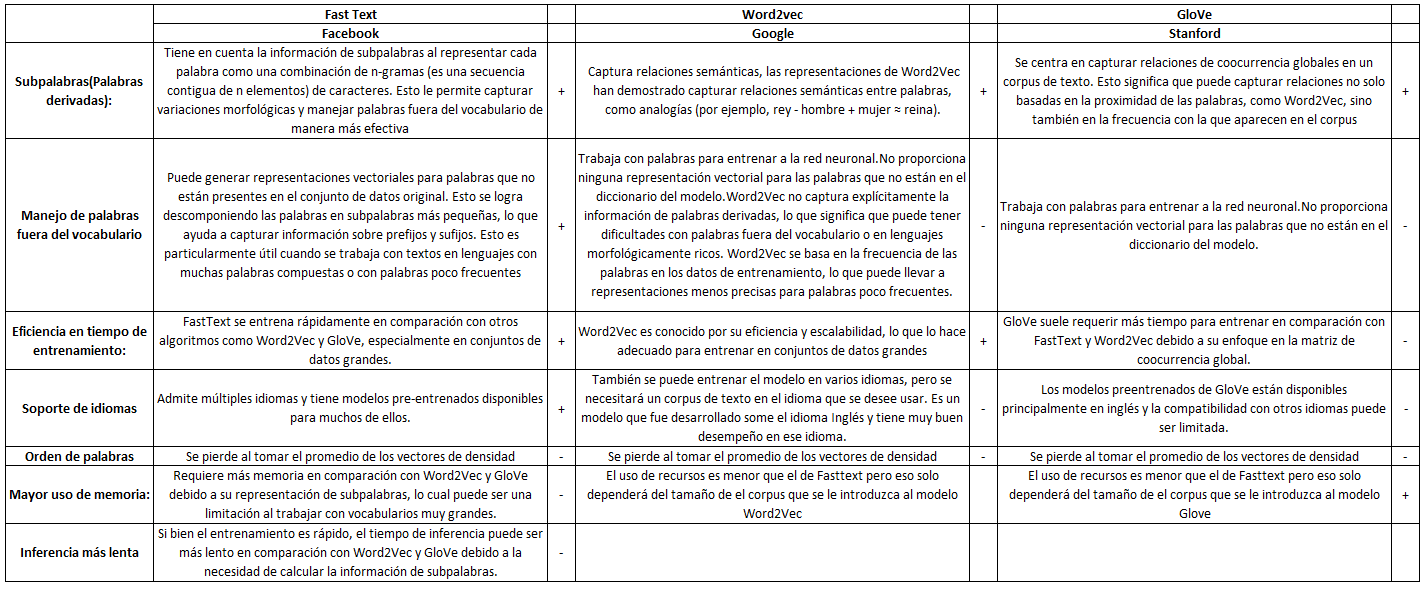


# **Ejercicio - 6.**
Utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300 para generar un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el “valor” será su vector embebido de dimensión 300. Este diccionario deberá ser del mismo tamaño que el vocabulario previo que hayas construido previamente.  https://fasttext.cc/docs/en/crawl-vectors.html

NOTA: Debido a la cantidad de recursos computacionales que demanda cargar los vectores FastText (son 2 millones de vectores), es recomendable que una vez que generes el nuevo vocabulario de vectores embebidos, guardes dicho diccionario en un archivo (pickle, npz o el que consideres más adecuado). Una vez realizado lo anterior, puedes borrar la variable de FastText para liberar memoria RAM. De esta manera, ya tienes tu vocabulario de vectores embebidos de acuerdo a los tokens que consideras más adecuados para tu problema y puedes usarlo rápidamente cuando lo necesites. En dado caso apóyense entre los miembros del equipo de tener dificultades para generar el vocabulario y por mientras puedes usar el archivo del vocabulario que alguno haya generado

## Código

In [ ]:
######################
## Ejercicio 6:      #
######################
def f_ej6(vocabulary):

    # Tomar modelo preentrenado
    ft = fasttext.load_model('cc.en.300.bin')

    # Obtener valores embebidos del vocabulario original
    embeddings = {word: ft.get_word_vector(word) for word in vocabulary.keys()}

    # Unit test 
    bool_ = len(embeddings) == len(vocabulary)
    print(f'Test: embeddings {len(vocabulary)} size...' + ( PASSED_STRING if bool_ else FAILED_STRING ))
    
    # Liberar y solo regresar los embeddings
    del ft
    return embeddings

embeddings = f_ej6(mivoc)

Test: embeddings 1443 size...✅  PASSED


## Comentario
Se crea un vocabulario embebido con los pesos obtenidos de fasttext; este vocabulario contiene 300 vectores de peso para cada palabra del vocabulario con lo que es posible determinar los pesos de los comentarios.

# **Ejercicio - 7.**
Una manera de utilizar los vectores embebidos con modelos de aprendizaje automático en documentos de texto, es asignar a cada comentario filtrado el vector embebido de dimensión 300 que resulta de promediar todos sus tokens. Así, en este ejercicio deberás generar los arreglos correspondientes para los conjuntos de entrenamiento, validación y prueba. Los llamaremos trainEmb, valEmb y testEmb, respectivamente. ¿Cuáles son sus dimensiones? ¿Se podrían usar para su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf? Responde a dichas preguntas. 


## Código

In [ ]:
######################
## Ejercicio 7:      #
######################

def f_docemb(documents, embeddings):
    # Declaramos un documento vacio
    document_embeddings = []
    # Para cada documento...
    for doc in documents:
        # Obetenemos los valores embebidos
        doc_embeddings = [embeddings[word] for word in doc if word in embeddings]
        
        if doc_embeddings:
            # Como un promedio
            average_embedding = np.mean(doc_embeddings, axis=0)
        else:
            # o Como 0
            average_embedding = np.zeros(300)  

        document_embeddings.append(average_embedding)
    return document_embeddings

def f_ej7():
    return f_docemb(train_x, embeddings), f_docemb(val_x, embeddings), f_docemb(test_x, embeddings)

trainEmb, valEmb, testEmb = f_ej7()

## Comentario

Para cada "review" o documento, encontramos lo que cada una de sus palabras representa y con eso formamos un promedio. Habrán ocasiones en las que no encontremos palabras, ya que nuestro vocabulario está filtrado por lo que algunos comentarios están vacios, de momento, los llenaremos con matrices 0. Si un comentario tiene puros 0, eso significa que no es posible obtener información de esta, sin embargo, tenmdrá una etiqueta. 

**¿Cuáles son las dimensiones de los arreglos con vectores embebidos?**

Las matrices trainEmb, valEmb y testEmb tienen dimensión (2100,300), (450, 300) y (450,300), respectivamente. Durante el proceso de representación de comentarios en vectores puede darse el caso que ninguna palabra del comentario exista en el vocabulario, por lo que la representación en vector de este comentario sería un arreglo de 0s. Sería conveniente eliminar estos registros, ya que introduce ruido al modelo que impacta en su poder predictivo.

**¿Se podrían usar para su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf?**

Aunque es posible combinar FastText y TF-IDF en un modelo NLP, no se puede representar directamente los vectores embebidos de FastText mediante una matriz TF-IDF. Cada enfoque tiene sus propias ventajas y desventajas, y su elección depende de la tarea específica que se esté abordando en NLP.

# **Ejercicio - 8.**
Utiliza los modelos de regresión lineal y bosque aleatorio (random forest) y encuentra sus desempeños (accuracy). Compara los resultados con los de la semana anterior. 


## Código

In [ ]:
######################
## Ejercicio 8:      #
######################

def f_ej8():

    # Funcion para encontrar mejor combinacion de parametros
    def best_params(model, params, x_train, y_train, x_val, y_val):
        # Variables iniciales
        best_score = -1
        best_params = None

        # Busqueda del mejor modelo basado en el conjunto de validación (sin cv)
        for params in ParameterGrid(params):
            model.set_params(**params)
            model.fit(x_train, y_train)
            score = model.score(x_val, y_val)
            if score > best_score:
                best_score = score
                best_params = params         
        return best_params


    # Hiperparametros
    LR_pargrd = {
           'C':[0.0001, 100, 20],
            'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
            'class_weight':['balanced'],
            'penalty':['l2']
                }
    # Mejores hiperparmetros
    LR_params = best_params(LogisticRegression(random_state=42), LR_pargrd, trainEmb, y_train, valEmb, y_val)
    # Entrenamiento con mejor modelo
    LR = LogisticRegression(random_state=42, **LR_params)
    LR.fit(trainEmb, y_train)


    # Hiperparametros
    RF_pargrd = {
              'ccp_alpha': [0.0,  0.005, 0.05, 0.1, ],
                'criterion': ['gini', 'entropy'],
                'max_depth': [1, 10, None],
                'min_samples_split': [2]
                }
    # Mejores hiperparmetros
    RF_params = best_params(RandomForestClassifier(random_state=42, n_jobs=-1), RF_pargrd, trainEmb, y_train, valEmb, y_val)
    # Entrenamiento con mejor modelo
    RF = RandomForestClassifier(random_state=42, n_jobs=-1, **RF_params)
    RF.fit(trainEmb, y_train)

    # Mostrar modelos
    print('LR: hiperparametros:')
    print(LR_params)
    print('LR: Train-accuracy: %.2f%%' % (100 * LR.score(trainEmb, y_train)))
    print('LR: Val-accuracy: %2.f%%' % (100 * LR.score(valEmb, y_val)))

    print('\n')

    print('RF: hiperparametros:')
    print(RF_params)
    print('RF: Train-accuracy: %.2f%%' % (100 * RF.score(trainEmb, y_train)))
    print('RF: Val-accuracy: %.2f%%' % (100 * RF.score(valEmb, y_val)))


    return LR, RF

LR, RF = f_ej8()

LR: hiperparametros:
{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
LR: Train-accuracy: 87.86%
LR: Val-accuracy: 82%


RF: hiperparametros:
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
RF: Train-accuracy: 99.86%
RF: Val-accuracy: 80.44%


## Comentario
Dadas las distancias entre en entrenamiento y validación, seleccionamos a la regresión logistica como el modelo con mejor desempeño y es el que utilizaremos para crear nuestra predicción contra el conjunto de prueba.

En comparación con los resultados obtenidos la semana pasada, se lograron scores más altos, pasando de un promedio de 70% de accuracy hasta un 80% aproximadamente.
Fasttext...

# **Ejercicio - 9.**
Obtener la matriz de confusión e interpretar sus valores. 


## Código

Test-accuracy con el mejor modelo 83.33%


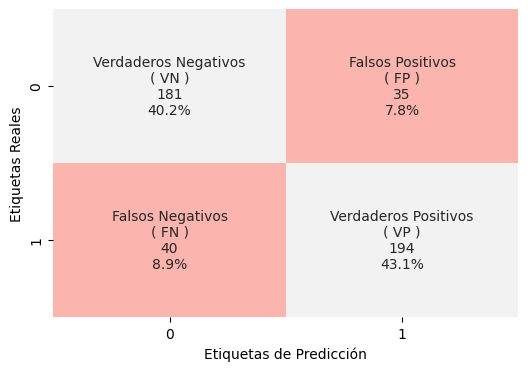

In [ ]:
######################
## Ejercicio 9:      #
######################

def f_ej9():
    # Mejor modelo
    mejor_modelo_Tfidf = LR

    print('Test-accuracy con el mejor modelo %.2f%%' % (100*mejor_modelo_Tfidf.score(testEmb, y_test)))

    # predecir valores
    pred = mejor_modelo_Tfidf.predict(testEmb)

    # Matriz de confusión
    confmtx = confusion_matrix(y_test, pred, labels=[0,1])
    txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
    vf = [ '( VN )', '( FP )', '( FN )', '( VP )']
    
    # Valores numéricos
    frecuencia = ["{0:0.0f}".format(value) for value in confmtx.flatten()]
    porcentaje = ["{0:.1%}".format(value) for value in confmtx.flatten()/np.sum(confmtx)]
    
    # Etiquetas
    labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(txt,vf, frecuencia,porcentaje)]
    labels = np.asarray(labels).reshape(2,2)

    # Crear matriz en pliot
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmtx, annot=labels, fmt='', cmap='Pastel1', cbar=False)
    ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
    plt.show()

f_ej9()

## Comentario
Con esto obtenemos un modelo con **83.33%** de accuracy para validar si un comentario es positivo o no basado en una regresión lineal y en vectores embebidos en lugar de diccionarios de palabras con matrices dispersas.

Recordemos que 0 representa a los comentarios malos y 1 a los comentarios buenos, con esto en mente esta es la lectura que podemos dar a la matriz de confusion:

VN= Mi modelo decia que mi comentario seria malo y su conclusión fue correcta -181- 40.2%

FP=Mi modelo decia que mi comentario seria bueno ,la realidad es que mi comentario es malo -35 -7.8%

FN= Mi modelo decia que mi comentario seria malo , la realidad es que mi comentario es bueno -40 -8.9%

VP=Mi modelo decia que mi comentario seria bueno y su conclusión fue correcta -194 43.1%

En general, la capacidad de predicción fue similar para ambos tipos de comentarios.

# **Ejercicio - 10.**
Comenta con tus compañeros de equipo los pasos realizados en esta actividad e incluyan sus conclusiones finales. 

## Comentario

La idea de los vectores embebidos para vocabularios resulta fascinante, el poder darle un significado funcional a a las palabras lo hace más intuitivo y sencillo de aceptar como algo que funciona. Estos métodos experimentados aquí, resultaron además en un aumento de desempeño e incluso de rendimiento; aunque está parte tiene su razón en el pre entrenamiento.

Resulta evidente que la limpieza sigue siendo un paso importante; estos vectores encuentran significados, cierto, pero si la palabra no es ubicable por faltas ortográficas o por falta de lemas, su valor sigue siendo cero. En particular observamos que se requiere menos limpieza pues estos modelos de hecho tienen palabras con peculiaridades que se aproximan más sencillo que a la análoga matriz de conteo, por lo que esto parece ser otra ventaja.

En general, una aproximación divertida e intuitiva. De costo mayor, cierto, pero dentro de un rango bastantea aceptable considerando los creces que ofrece el uso.

La parte interesante que quedaría por estudiar es la estructura, seguimos trabajando con palabras por separado, el orden no importa, esperemos ver más soluciones de esto en futuros ejercicios.

# FIN DE LA ACTIVIDAD DE LA SEMANA 5